In [ ]:
# @author: Josiah Kimani
# @date: 2025-06-12
# @description: This script installs the required packages for the MDS example notebook.
# Sklearn version 1.7.0 supports normalized stress for metric MDS while earlier versions dont.
# Restart runtime to use the new version
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [ ]:
# Verify the installation
import sklearn
print(sklearn.__version__)

1.7.0


In [ ]:
# @title Import Libraries
# Import necessary libraries for MDS example notebook
from google.colab import drive
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform


In [ ]:
# @title Mount Drive
# Mount Google Drive to access datasets and save results
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Load Datasets(Forecasts and ERA5)

# Drive Data Path
# Define the path to the Google Drive where the datasets are stored
# This path should be updated to match your Google Drive structure.
drive_data_path = "/content/drive/MyDrive/MastersProject/Data/"

# Load ERA5 data: Geopotential Height at 500 hPa pressure level
# Columns : time	longitude	latitude	era5
df = pd.read_pickle(drive_data_path + "era5_ml_setup_500geopotential_32x64_2020.pkl")


# Lead times under study: 9 lead times
lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]


# Load the downloaded data per leadtime: Geopotential Height at 500 hPa
# Columns in the data: time	longitude	latitude	graphcast	pangu	neuralgcm	ifshres keisler
# Drop Keisler forecasts due to missing values as identified before.
# Rename columns (graphcast	pangu	neuralgcm	ifshres) to have the leadtime extension
# Create a df comprised of ERA5 and the model forecasts of all the lead times

for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(drive_data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight","keisler"])
    df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    df = df.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")



48
72
96
120
144
168
192
216
240


In [5]:
print(df.shape)
df.head()


(1556480, 41)


,time,longitude,latitude,era5,area_weight,graphcast_lt48,pangu_lt48,neuralgcm_lt48,ifshres_lt48,graphcast_lt72,...,neuralgcm_lt192,ifshres_lt192,graphcast_lt216,pangu_lt216,neuralgcm_lt216,ifshres_lt216,graphcast_lt240,pangu_lt240,neuralgcm_lt240,ifshres_lt240
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# @title Pairwise RMSE
# Calculate the pairwise RMSE between ERA5 and model forecasts for each lead time.

def calculate_pairwise_rmse(df, columns):
    """Calculates the pairwise RMSE between specified columns in a DataFrame.

    Args:
      df: The input DataFrame.
      columns: A list of column names to calculate RMSE for.

    Returns:
      A pandas DataFrame representing the pairwise RMSE matrix.
    """

    n = len(columns)
    rmse_matrix = pd.DataFrame(index=columns, columns=columns)

    for i in range(n):
      for j in range(i, n):  # Only calculate upper triangle, as it is symmetric
          col1 = columns[i]
          col2 = columns[j]

          rmse = np.sqrt(((df[col1] - df[col2])**2 * df["area_weight"]).mean() / df["area_weight"].mean())
          rmse_matrix.loc[col1, col2] = rmse
          rmse_matrix.loc[col2, col1] = rmse # Assign to the lower triangle as well

    return rmse_matrix


In [7]:
pairwise_rmse_result = calculate_pairwise_rmse(df, df.drop(columns=["time", "latitude", "longitude", "area_weight"]).columns)
pairwise_rmse_result

,era5,graphcast_lt48,pangu_lt48,neuralgcm_lt48,ifshres_lt48,graphcast_lt72,pangu_lt72,neuralgcm_lt72,ifshres_lt72,graphcast_lt96,...,neuralgcm_lt192,ifshres_lt192,graphcast_lt216,pangu_lt216,neuralgcm_lt216,ifshres_lt216,graphcast_lt240,pangu_lt240,neuralgcm_lt240,ifshres_lt240
era5,0.0,69.52879,76.12659,60.464654,74.7362,115.160156,125.908476,104.454006,124.894767,179.164564,...,551.703091,604.664126,647.629019,683.687605,645.850939,697.657471,728.373444,761.913107,726.667722,777.058039
graphcast_lt48,69.52879,0.0,66.435531,63.835288,69.562836,91.673366,120.948742,102.458328,121.567788,165.414204,...,549.804622,601.975738,643.491621,680.550451,643.398951,694.722239,724.613605,759.067406,724.312178,774.008048
pangu_lt48,76.12659,66.435531,0.0,64.263745,71.814378,110.896679,100.018717,100.077412,121.213137,175.272829,...,549.73798,602.304792,645.084415,678.758503,643.617862,695.178149,726.037385,757.81039,724.676746,774.481985
neuralgcm_lt48,60.464654,63.835288,64.263745,0.0,66.478464,107.481173,114.976634,85.107984,116.75453,172.731817,...,547.748071,600.681579,644.049508,679.203366,642.125947,693.867627,724.959095,757.865115,723.3162,773.305509
ifshres_lt48,74.7362,69.562836,71.814378,66.478464,0.0,115.625124,123.267632,103.623619,98.8044,178.030278,...,547.990833,597.454531,643.744313,678.514237,641.993329,691.018482,724.197653,756.870119,722.977513,770.46761
graphcast_lt72,115.160156,91.673366,110.896679,107.481173,115.625124,0.0,105.998268,102.279047,113.080117,141.27562,...,546.330503,599.176339,638.102531,677.407272,640.330593,691.966889,720.253608,755.947946,721.159351,771.329952
pangu_lt72,125.908476,120.948742,100.018717,114.976634,123.267632,105.998268,0.0,104.273869,119.072937,169.670487,...,546.979087,600.910156,642.850713,676.067157,641.900696,694.287017,724.433572,755.119351,722.736707,773.796777
neuralgcm_lt72,104.454006,102.458328,100.077412,85.107984,103.623619,102.279047,104.273869,0.0,111.085068,164.781352,...,543.489376,597.649467,641.099325,676.628506,638.765476,691.334967,722.668431,755.476509,720.292174,771.003788
ifshres_lt72,124.894767,121.567788,121.213137,116.75453,98.8044,113.080117,119.072937,111.085068,0.0,179.05373,...,545.504825,592.959438,641.726327,676.606509,639.997349,687.753572,722.694751,754.938584,720.975839,767.5837
graphcast_lt96,179.164564,165.414204,175.272829,172.731817,178.030278,141.27562,169.670487,164.781352,179.05373,0.0,...,540.584592,594.881164,630.481952,673.319985,635.429849,687.925941,713.511194,751.003819,716.578367,767.484722


In [ ]:
# @title MDS plot using the values in pairwise_rmse_result
# This section applies MDS to the pairwise RMSE results and plots the coordinates.
# Ensure the pairwise RMSE result is a square matrix

# Convert the DataFrame to a distance matrix (NumPy array)
distance_matrix = pairwise_rmse_result.values

# Apply MDS
mds = MDS(n_components=2,  metric=True, n_init=4, max_iter=300, eps=1e-6,
                   n_jobs=-1,random_state=2,
                   dissimilarity='precomputed', normalized_stress=True )
coords = mds.fit_transform(distance_matrix)

In [ ]:
# Check the stress value to ensure MDS converged properly
mds.stress_

np.float64(0.2632330331722619)

In [ ]:
coords

array([[ 141.87451861,  265.23929301],
       [ 124.3371148 ,  257.91740819],
       [ 155.31256375,  245.14720474],
       [ 136.37360425,  245.70083789],
       [ 162.90344708,  235.22925603],
       [ 137.83200377,  204.61716444],
       [ 183.30133159,  204.55356403],
       [ 115.69269364,  222.60533942],
       [ 166.17936   ,  193.60084158],
       [  47.62362538,  235.64493119],
       [  27.08289102,  213.83621084],
       [  77.50041838,  178.90397149],
       [  18.43325183,  267.53509827],
       [ -20.85023869,  129.10037323],
       [ 126.37461162,   59.97795681],
       [  37.76387573,   94.12624213],
       [ -78.48250482,  212.81864047],
       [ 272.69470089,   33.10368674],
       [ 194.13976961,  -53.67174784],
       [  16.26035507,  -25.4671245 ],
       [-147.70412988,   73.07907464],
       [ 135.50544591, -194.38598652],
       [ 292.9624685 , -213.46281398],
       [ 320.3243348 ,  -96.84467607],
       [ 416.83806926, -120.1379486 ],
       [   6.36962783, -3

In [11]:
coords.shape

(37, 2)

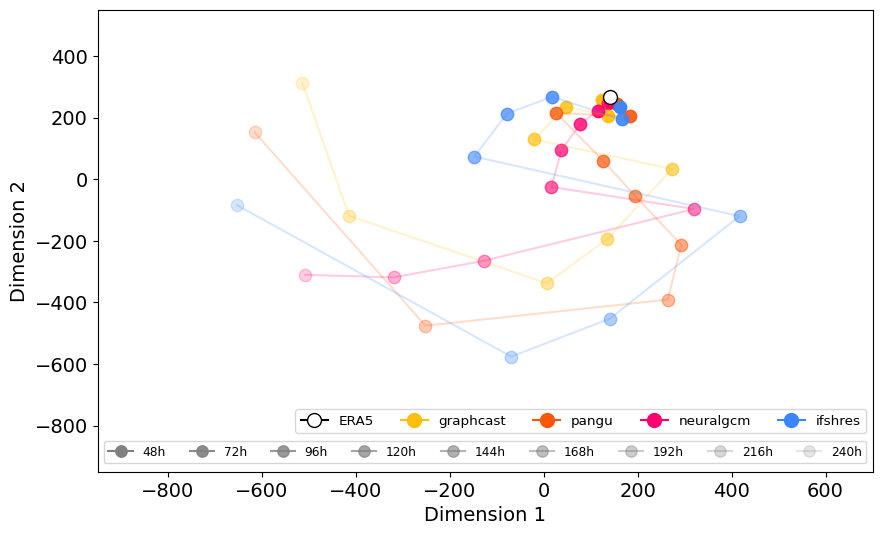

In [ ]:
# @title Create the plot
# Create a scatter plot of the MDS coordinates with different colors for each dataset

color_dict = {"graphcast": "#ffbe0b", "pangu": "#fb5607", "neuralgcm": "#ff006e", "ifshres": "#3a86ff"}

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.figure(figsize=(10, 6))
for i, label in enumerate(pairwise_rmse_result.index[1:]):
    if "era5" in label:
        dataset_color = "black"
    elif "graphcast" in label:
        dataset_color = color_dict["graphcast"]
    elif "pangu" in label:
        dataset_color = color_dict["pangu"]
    elif "neuralgcm" in label:
        dataset_color = color_dict["neuralgcm"]
    elif "ifshres" in label:
        dataset_color = color_dict["ifshres"]
    else:
        continue


    if "lt48" in label:
        lead_transparency=1
    elif "lt72" in label:
        lead_transparency=0.9
    elif "lt96" in label:
        lead_transparency=0.8
    elif "lt120" in label:
        lead_transparency=0.7
    elif "lt144" in label:
        lead_transparency=0.6
    elif "lt168" in label:
        lead_transparency=0.5
    elif "lt192" in label:
        lead_transparency=0.4
    elif "lt216" in label:
        lead_transparency=0.3
    elif "lt240" in label:
        lead_transparency=0.2
    plt.scatter(coords[i+1, 0], coords[i+1, 1], color=dataset_color, alpha=lead_transparency, s=80)
    #plt.annotate(label, (coords[i, 0], coords[i, 1]))  # Add labels to points

plt.scatter(coords[0, 0], coords[0, 1], facecolors="white", edgecolors="black", alpha=1, s=100) #s is the marker size

def get_dataset_coords(coords, labels, dataset_name):
    new_coords = []
    for i, label in enumerate(labels):
        if dataset_name in label:
            new_coords.append(coords[i])
    return np.array(new_coords)

for dataset, color in color_dict.items():
    dataset_coords = get_dataset_coords(coords=coords, labels=pairwise_rmse_result.index, dataset_name=dataset)
    plt.plot(dataset_coords[:, 0], dataset_coords[:, 1], color=color, alpha=0.2)


# plt.title('MDS of Pairwise RMSE (48-240 Hours Lead Time)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')


legend_elements = [
    plt.Line2D([0], [0], marker='o', color='k', label='ERA5', markerfacecolor='white', markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["graphcast"], label='graphcast', markerfacecolor=color_dict["graphcast"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["pangu"], label='pangu', markerfacecolor=color_dict["pangu"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["neuralgcm"], label='neuralgcm', markerfacecolor=color_dict["neuralgcm"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["ifshres"], label='ifshres', markerfacecolor=color_dict["ifshres"], markersize=10)
    ]

legend1 = plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.15), loc='upper right', ncol=6, fontsize=9.7)

# Create the second legend (for lead times)
lead_time_alphas = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
lead_time_labels = ['48h', '72h', '96h', '120h', '144h', '168h', '192h', '216h', '240h']

legend_elements2 = []
for alpha, label in zip(lead_time_alphas, lead_time_labels):
    legend_elements2.append(plt.Line2D([0], [0], marker='o', color='gray', label=label, alpha=alpha, markersize=8.2))

legend2 = plt.legend(handles=legend_elements2, bbox_to_anchor=(1, 0.08), ncol=9, fontsize=8.7)

# Add the first legend back to the plot (as it was removed by the second legend call)
plt.gca().add_artist(legend1)


plt.xlim([-950, 700])  # Set x-axis limits
plt.ylim([-950, 550])
plt.grid(False)
plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/MDS of Pairwise RMSE (48-240 Hours Lead Time).pdf', dpi=300, bbox_inches="tight")



In [ ]:
# @title Distance from ERA5
# Calculate the distance of each model's MDS coordinates from the ERA5 coordinates for each lead time.
# Extract ERA5 coordinates (first row) and model coordinates (remaining rows)
# Split into ERA5 and model coordinates
coords_era5 = coords[0]              # shape (2,)
coords_models = coords[1:]           # shape (36, 2)

# Setup
model_names = ['GraphCast', 'Pangu', 'NeuralGCM', 'IFSHRES']
lead_times = [48, 72, 96, 120, 144, 168, 192, 216, 240]
n_models = len(model_names)

# Loop over lead times
for i, lead in enumerate(lead_times):
    start_idx = i * n_models
    end_idx = start_idx + n_models
    coords_slice = coords_models[start_idx:end_idx]  # shape (4, 2)

    distances = np.linalg.norm(coords_slice - coords_era5, axis=1)

    print(f"\nLead time {lead}h:")
    for name, dist in zip(model_names, distances):
        print(f"{name:12s}: {dist:.2f}")




Lead time 48h:
GraphCast   : 19.00
Pangu       : 24.17
NeuralGCM   : 20.30
IFSHRES     : 36.64

Lead time 72h:
GraphCast   : 60.76
Pangu       : 73.48
NeuralGCM   : 50.03
IFSHRES     : 75.65

Lead time 96h:
GraphCast   : 98.79
Pangu       : 125.78
NeuralGCM   : 107.69
IFSHRES     : 123.46

Lead time 120h:
GraphCast   : 212.16
Pangu       : 205.85
NeuralGCM   : 200.30
IFSHRES     : 226.51

Lead time 144h:
GraphCast   : 266.46
Pangu       : 323.17
NeuralGCM   : 316.68
IFSHRES     : 347.54

Lead time 168h:
GraphCast   : 459.67
Pangu       : 501.98
NeuralGCM   : 403.67
IFSHRES     : 473.41

Lead time 192h:
GraphCast   : 618.38
Pangu       : 667.70
NeuralGCM   : 594.32
IFSHRES     : 718.55

Lead time 216h:
GraphCast   : 676.10
Pangu       : 839.26
NeuralGCM   : 744.37
IFSHRES     : 867.54

Lead time 240h:
GraphCast   : 657.35
Pangu       : 765.63
NeuralGCM   : 868.12
IFSHRES     : 868.29


In [ ]:
#  @title Apply 3D MDS
# This section applies MDS in 3D to the pairwise RMSE results and plots the coordinates.
# Ensure the pairwise RMSE result is a square matrix
mds_3d = MDS(n_components=3,   metric=True, n_init=4, max_iter=300, eps=1e-6,
                   n_jobs=-1,random_state=2,
                   dissimilarity='precomputed', normalized_stress=True)
coords_3d = mds_3d.fit_transform(distance_matrix)

In [ ]:
# Check the stress value to ensure MDS converged properly
mds_3d.stress_

np.float64(0.18438355845808405)

In [17]:
coords_3d

array([[-127.60179104, -117.66804215,  182.39445397],
       [-143.69656472, -101.44889764,  163.10158955],
       [-120.98600919,  -90.80200728,  198.48428245],
       [-116.71992372, -105.81781131,  160.29977058],
       [ -91.313703  , -111.01227976,  177.48120989],
       [-164.92440412,  -67.63054748,  150.68420882],
       [-148.3727539 ,  -49.55819757,  201.96206646],
       [-107.46152565,  -74.55500478,  142.2049825 ],
       [ -54.20223821,  -97.50994959,  182.84770303],
       [ -91.49506971,    4.82886928,  227.28944444],
       [-163.95086404,   30.68534617,  208.36741105],
       [-145.49496334,   -5.10947955,  131.55542299],
       [   0.88033545,  -64.77179845,  221.05718486],
       [-156.17506682,  117.13278056,  146.14008677],
       [ -64.20838156,  143.9371468 ,  237.9707575 ],
       [   3.92030554,   67.70214011,  201.94657769],
       [  98.08446171,  -10.20488064,  223.6963721 ],
       [ -14.63666765,  228.77557886,   88.7197579 ],
       [-115.86322449,  281.

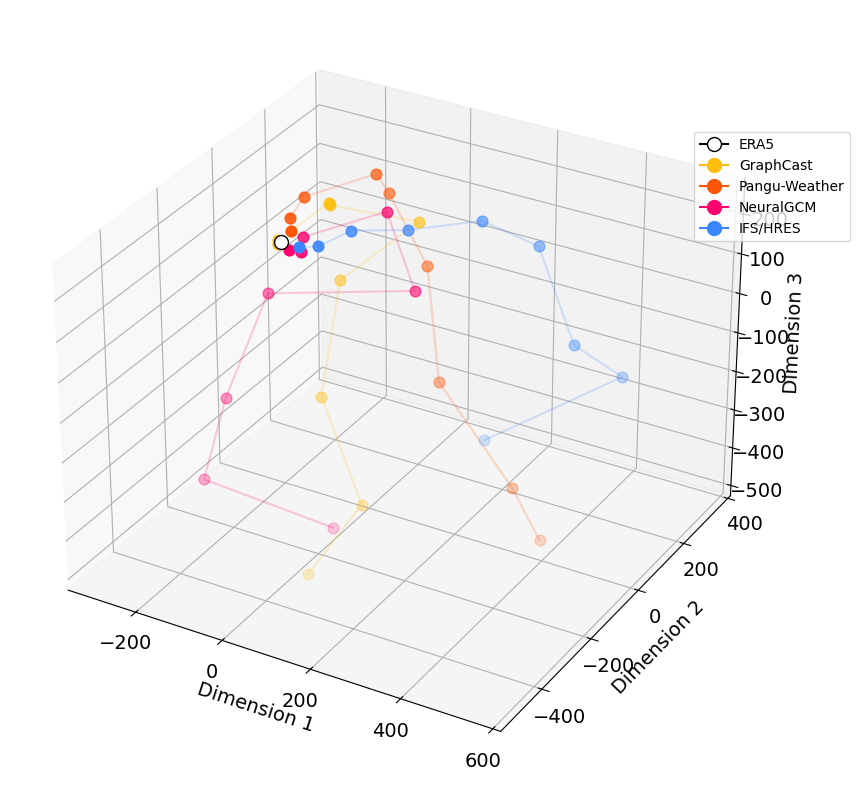

In [ ]:
# @title Create the 3D plot
# Create a 3D scatter plot of the MDS coordinates with different colors for each dataset
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plots
import numpy as np

color_dict = {
    "graphcast": "#ffbe0b",
    "pangu": "#fb5607",
    "neuralgcm": "#ff006e",
    "ifshres": "#3a86ff"
}

# Set up figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(pairwise_rmse_result.index[1:]):  # Skip ERA5 at index 0
    if "graphcast" in label:
        dataset_color = color_dict["graphcast"]
    elif "pangu" in label:
        dataset_color = color_dict["pangu"]
    elif "neuralgcm" in label:
        dataset_color = color_dict["neuralgcm"]
    elif "ifshres" in label:
        dataset_color = color_dict["ifshres"]
    else:
        dataset_color = "black"

    # Transparency for lead times
    if "lt48" in label:
        lead_transparency = 1
    elif "lt72" in label:
        lead_transparency = 0.9
    elif "lt96" in label:
        lead_transparency = 0.8
    elif "lt120" in label:
        lead_transparency = 0.7
    elif "lt144" in label:
        lead_transparency = 0.6
    elif "lt168" in label:
        lead_transparency = 0.5
    elif "lt192" in label:
        lead_transparency = 0.4
    elif "lt216" in label:
        lead_transparency = 0.3
    elif "lt240" in label:
        lead_transparency = 0.2

    ax.scatter(coords_3d[i+1, 0], coords_3d[i+1, 1], coords_3d[i+1, 2], color=dataset_color, alpha=lead_transparency, s=60)

# ERA5 reference point
ax.scatter(coords_3d[0, 0], coords_3d[0, 1], coords_3d[0, 2], color='white', edgecolor='black', s=100)

# Connect points for each model
def get_dataset_coords(coords, labels, dataset_name):
    new_coords = []
    for i, label in enumerate(labels):
        if dataset_name in label:
            new_coords.append(coords[i])
    return np.array(new_coords)

for dataset, color in color_dict.items():
    dataset_coords = get_dataset_coords(coords=coords_3d, labels=pairwise_rmse_result.index, dataset_name=dataset)
    if dataset_coords.shape[0] > 1:
        ax.plot(dataset_coords[:, 0], dataset_coords[:, 1], dataset_coords[:, 2], color=color, alpha=0.2)

# Axes labels and title
# ax.set_title('3D MDS of Pairwise RMSE (48-240 Hours Lead Time)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Legends
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='k', label='ERA5', markerfacecolor='white', markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["graphcast"], label='GraphCast', markerfacecolor=color_dict["graphcast"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["pangu"], label='Pangu-Weather', markerfacecolor=color_dict["pangu"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["neuralgcm"], label='NeuralGCM', markerfacecolor=color_dict["neuralgcm"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["ifshres"], label='IFS/HRES', markerfacecolor=color_dict["ifshres"], markersize=10)
]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.1, 0.85))

# Save figure
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/3D_MDS_Pairwise_RMSE.pdf', dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# @title Create the dendrogram plot
# This section creates a dendrogram from the pairwise RMSE results.
# Ensure the pairwise RMSE result is a square matrix
# Convert the DataFrame to a NumPy array
distance_matrix = pairwise_rmse_result.values

# Since the RMSE matrix is symmetric and represents distances,
# convert it to a condensed distance matrix
condensed_distance = squareform(distance_matrix)

# Compute the linkage matrix using a method of your choice (e.g., 'average')
Z = linkage(condensed_distance, method='average')




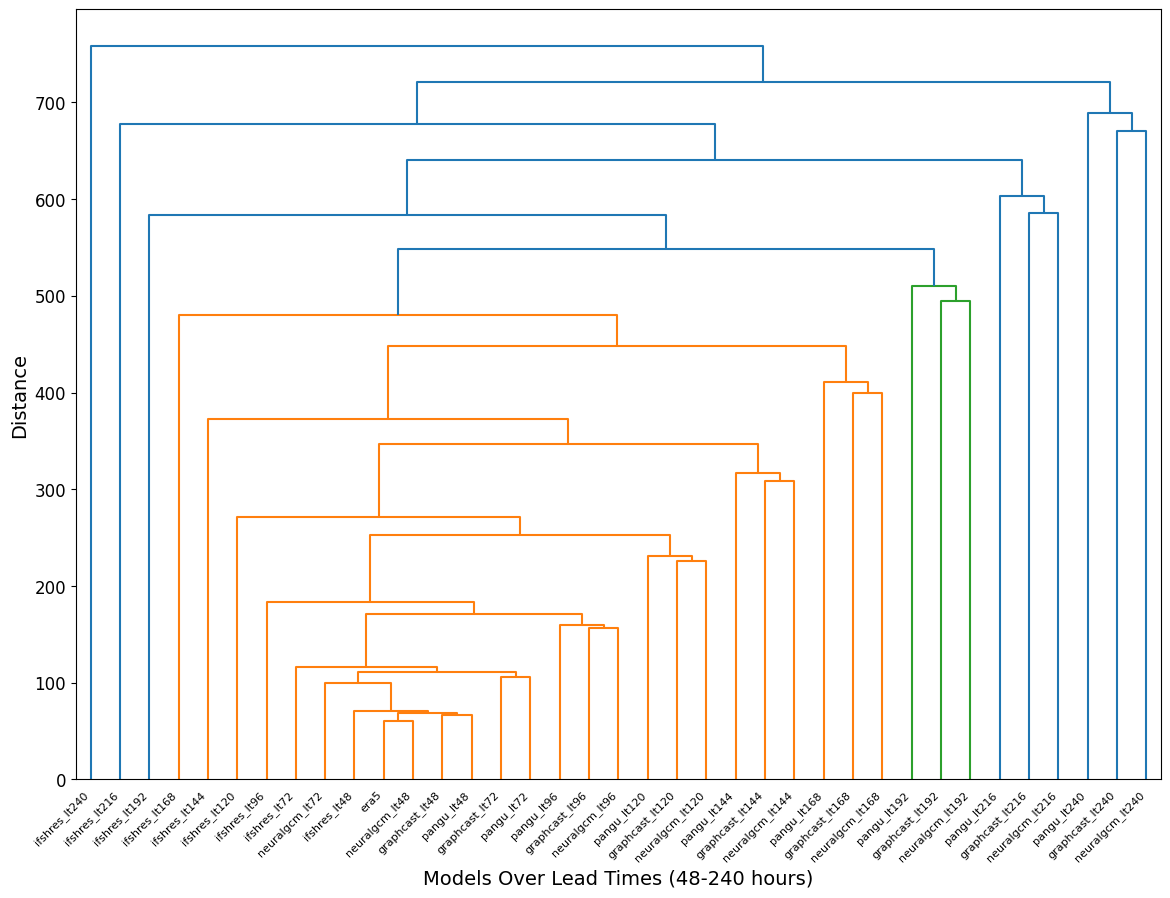

In [ ]:
# @title Dendrogram Plot
# This function creates a dendrogram plot from the linkage matrix and labels.
def dendrogram_plot(linkage_matrix, labels):
  # Create the dendrogram plot
  plt.rcParams['axes.titlesize'] = 16
  plt.rcParams['axes.labelsize'] = 14
  plt.rcParams['xtick.labelsize'] = 10
  plt.rcParams['ytick.labelsize'] = 12

  plt.figure(figsize=(14, 10))
  dendrogram(linkage_matrix, labels=labels, leaf_rotation=90)
  # plt.title('Hierarchical Clustering Dendrogram of Pairwise RMSE of Models(48-240 Hours Lead Time)')
  plt.xlabel('Models Over Lead Times (48-240 hours)')
  plt.ylabel('Distance')
  plt.xticks(rotation=45, ha='right')

  plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/Hierarchical Clustering Dendrogram of Pairwise RMSE of Models(48-240 Lead Time).pdf', dpi=300, bbox_inches="tight")

  plt.show()

dendrogram_plot(Z, pairwise_rmse_result.index)